In [1]:
import rioxarray
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
import geopandas as gpd
import glob
from osgeo import gdal

%matplotlib inline


In [2]:
# load mndwi
mndwi_file_list = glob.glob('/mnt/g/timeseries/pune/*tif')
mndwi_file_list.sort()
dates = []
for d in mndwi_file_list:
    date = d[-14:-4]
    dates.append(date)
from datetime import datetime
dt = [datetime.strptime(date,'%Y-%m-%d').date() for date in dates]


In [3]:
mndwi_file_list

['/mnt/g/timeseries/pune/Pune_MNDWI_1993-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1994-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1995-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1996-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1997-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1998-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_1999-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2000-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2001-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2008-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2009-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2013-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2014-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2015-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2016-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2017-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2018-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2019-10-15.tif',
 '/mnt/g/timeseries/pune/Pune_MNDWI_2020-10-15

In [4]:
pwd

'/mnt/g/timeseries/Water_Resource_Management-main/python_based_assessment'

In [5]:
dates

['1993-10-15',
 '1994-10-15',
 '1995-10-15',
 '1996-10-15',
 '1997-10-15',
 '1998-10-15',
 '1999-10-15',
 '2000-10-15',
 '2001-10-15',
 '2008-10-15',
 '2009-10-15',
 '2013-10-15',
 '2014-10-15',
 '2015-10-15',
 '2016-10-15',
 '2017-10-15',
 '2018-10-15',
 '2019-10-15',
 '2020-10-15',
 '2021-10-15',
 '2022-10-15',
 '2023-10-15']

In [6]:
type(dt[0])

datetime.date

In [7]:
# convert tiff files to xarray dataset

rasters = []
for f in mndwi_file_list:
    rasters.append(xr.open_dataset(f))
ds = xr.concat(rasters, pd.to_datetime(dt))
ds = ds.rename({'band_data':'mndwi','concat_dim':'time'})
ds = ds.rio.write_crs(4326, inplace=True)

In [8]:
ds = ds.squeeze()

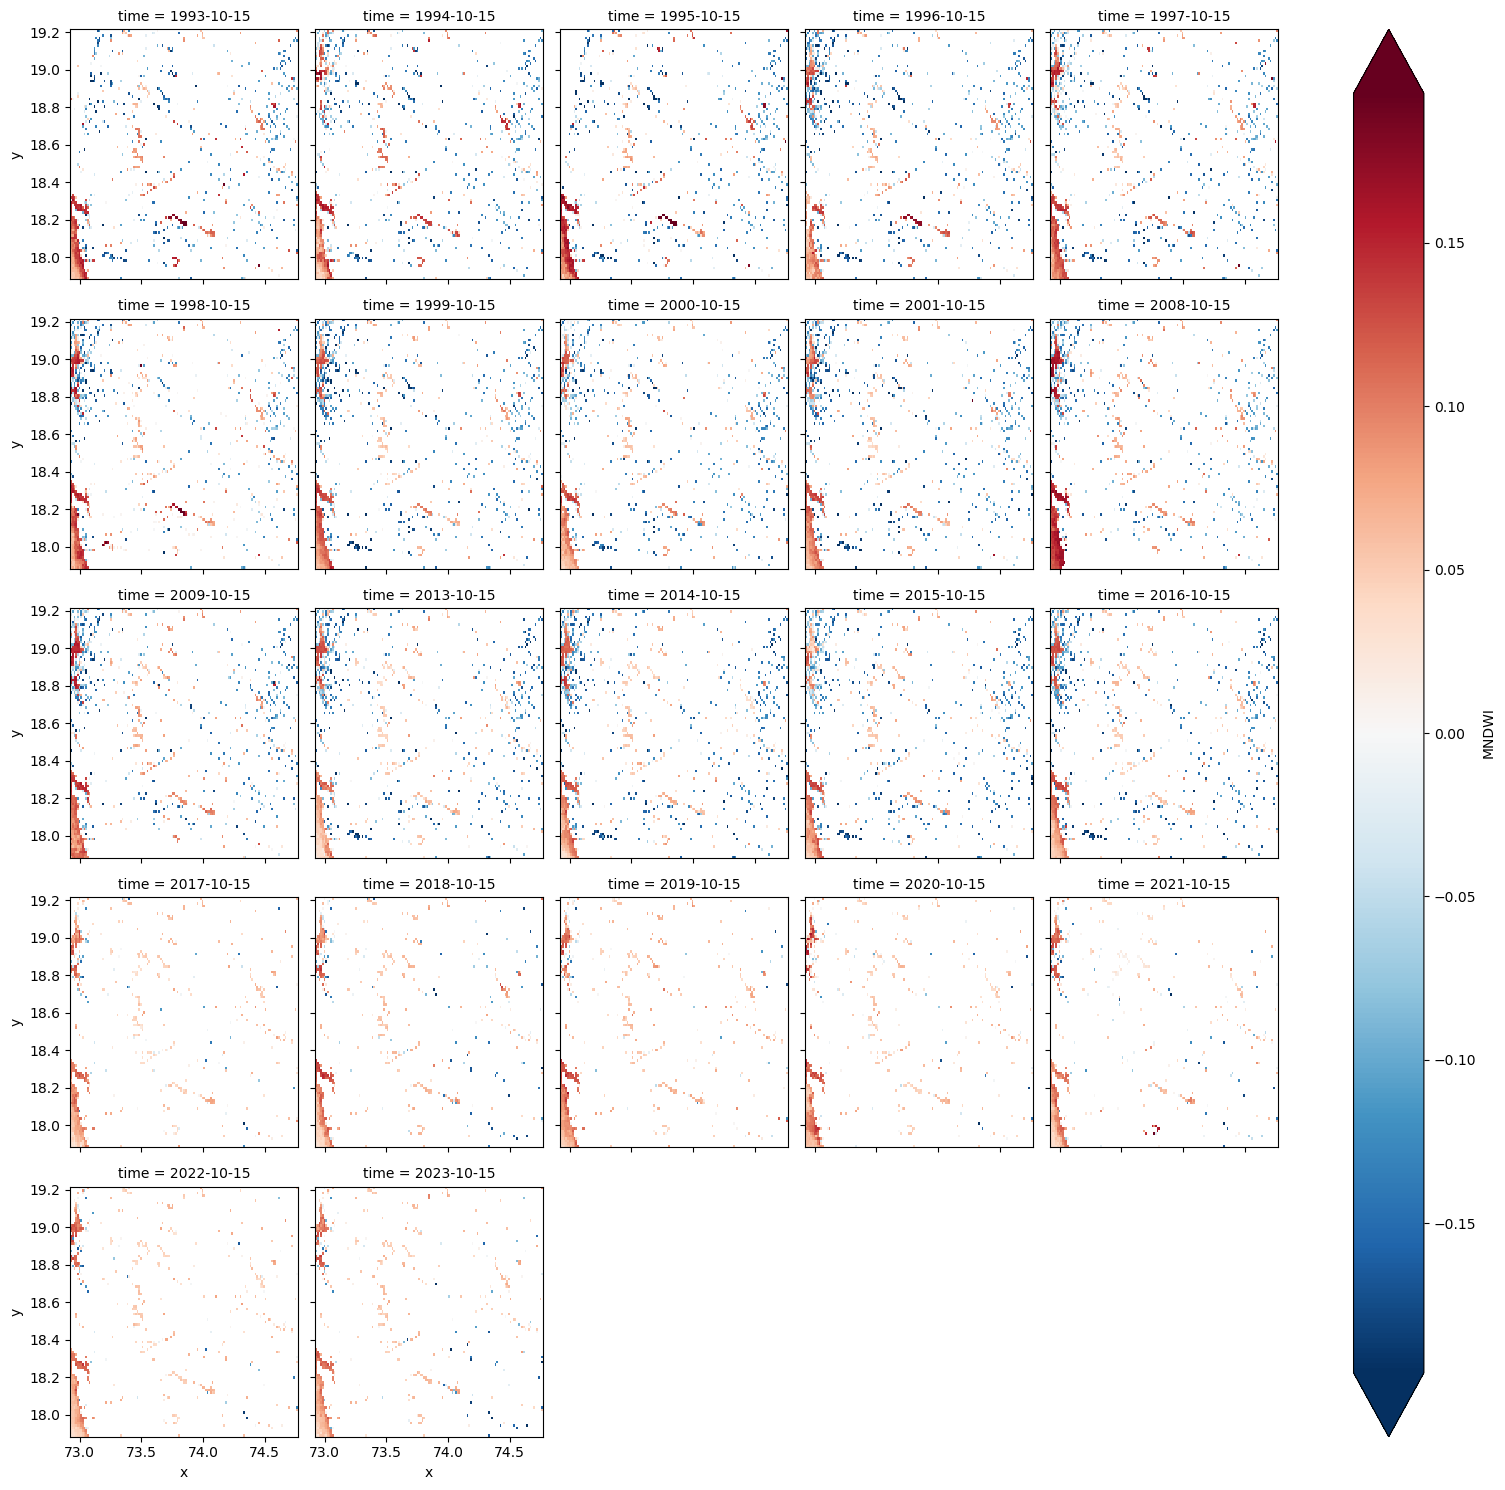

In [9]:
# A quick plot of the MNDWI time-series for every nth pixel - DO NOT do this at full resolution - your Kernal will die. 
nth = 50
ds2 = ds.mndwi.sel(x=slice(None,None,nth), y=slice(None,None,nth)) # We are selecting nth lat and nth long. If you want to clip, replace None with lat-long vals.
p = ds2.plot(col='time', col_wrap=5, robust=True) #vmin = 0, vmax=1) # You can use vmin/vmax to bound the colour scales.

In [ ]:
# # You can save above created dataset from tiffs as netCDF stack:
# ds.to_netcdf('mndwi.nc', encoding={'mndwi':{'dtype':'float32'}}, engine='h5netcdf')

In [ ]:
# dsW = xr.load_dataset('mndwi.nc')
dsW = ds

In [13]:
dsW.mndwi.rio.crs

CRS.from_epsg(4326)

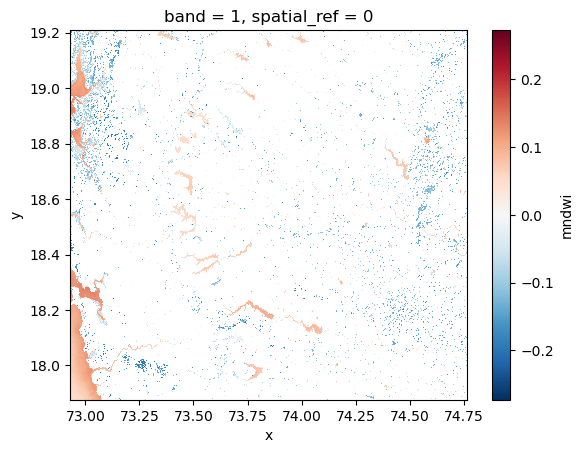

In [14]:
dsW.mndwi.mean('time').plot()

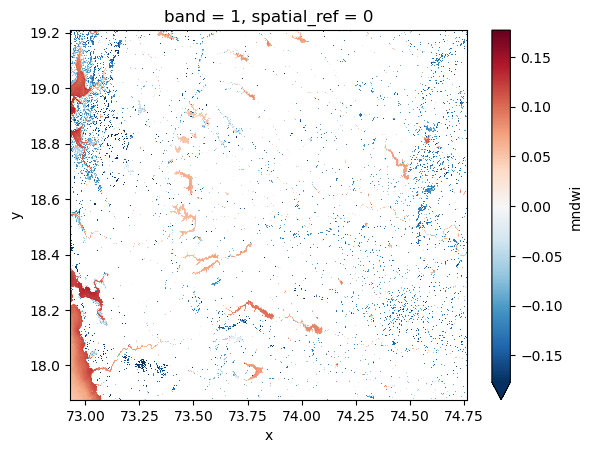

In [15]:
dsW.mndwi.mean('time').plot(robust=True)

In [18]:
# Calculating wet/dry binary dataset based on pre-defined mndwi threshold.

mndwi_binary = xr.where(dsW.mndwi>0, 1,0) #I am encoding wet as 1 and dry as 0.

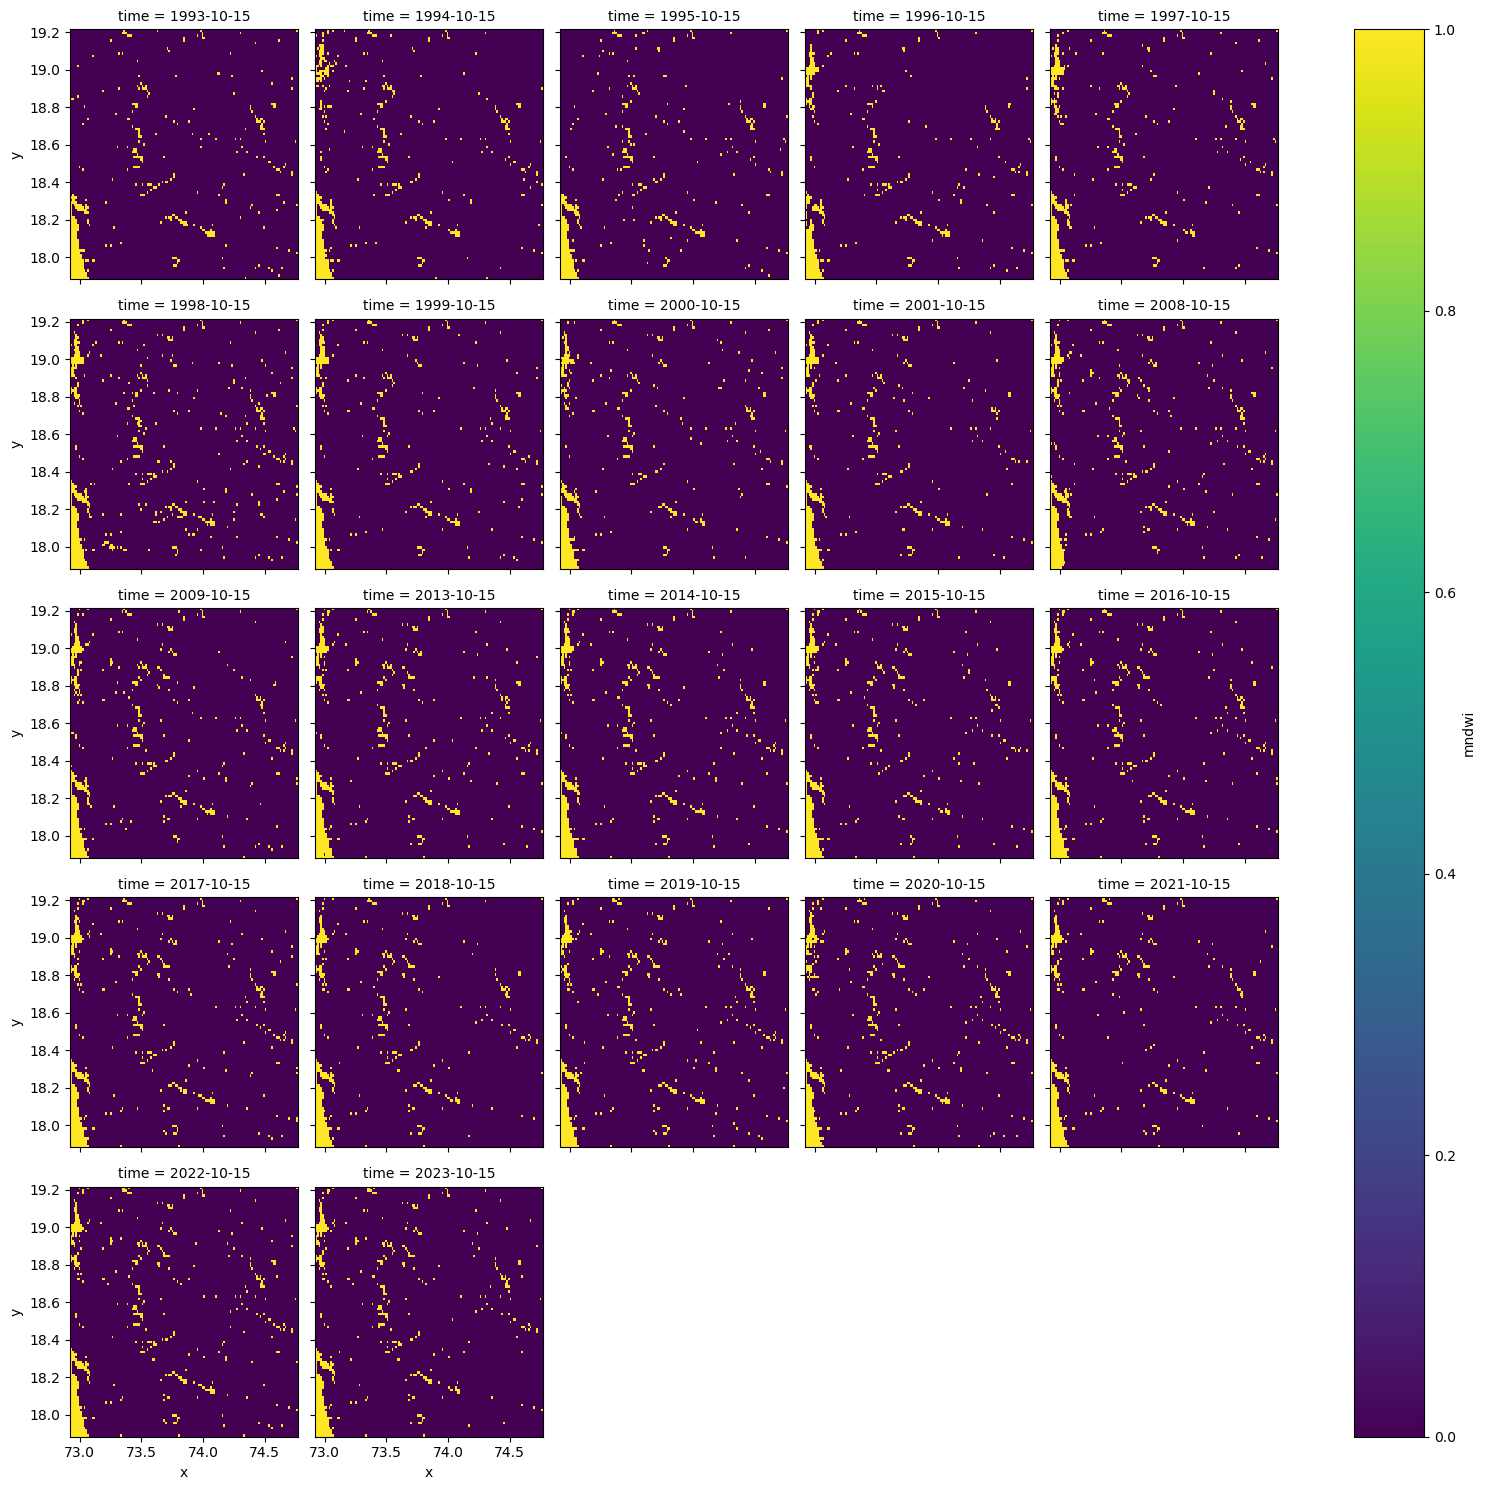

In [21]:
# A quick plot of the binary MNDWI time-series for every nth pixel 
nth = 50
ds2 = mndwi_binary.sel(x=slice(None,None,nth), y=slice(None,None,nth)) # We are selecting nth lat and nth long. If you want to clip, replace None with lat-long vals.
p = ds2.plot(col='time', col_wrap=5, robust=True)

In [22]:
# Wetness percent calculation - for whole dataset. 
wetPercent = mndwi_binary.sum('time')*100/len(mndwi_binary.time)

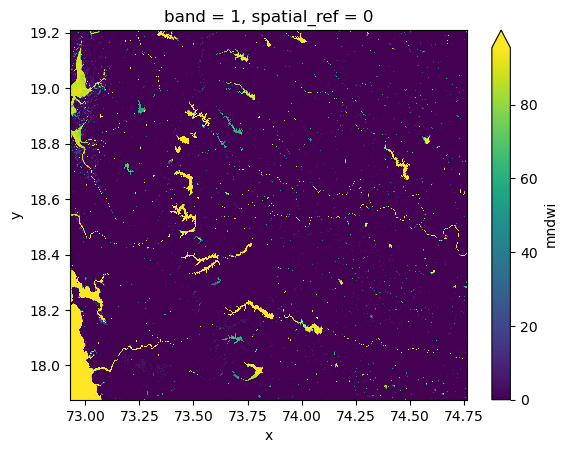

In [23]:
wetPercent.plot(robust=True)

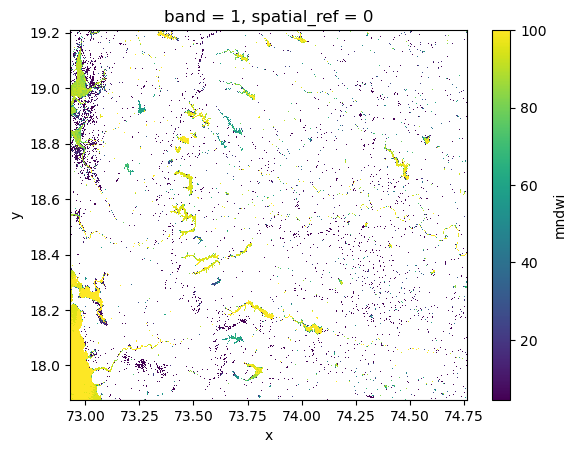

In [24]:
wetPercent.where(wetPercent>0).plot(robust=True)

In [ ]:
dsV = xr.load_dataset('datasets/indices/ndvi_1987_2020.nc')

In [ ]:
dsV.ndvi.mean('time').plot()

In [ ]:
#A better visualisation
dsV.ndvi.mean('time').plot(robust=True)

In [ ]:
ds = xr.merge([dsW,dsV])

In [ ]:
ds

In [ ]:
ds.ndvi.mean('time').plot()

# What went wrong above???

In [ ]:
# dsV_test = dsV.rio.reproject_match(dsW)

In [ ]:
dsV = dsV.rio.write_crs(4326, inplace=True)
dsW = dsW.rio.write_crs(4326, inplace=True)

In [ ]:
dsV

In [ ]:
dsV2 = dsV.rio.reproject_match(dsW)

In [ ]:
ds2 = xr.merge([dsW,dsV2])

In [ ]:
ds2.ndvi.mean('time').plot()

In [ ]:
correlate = xr.corr(ds2.mndwi,ds2.ndvi, dim='time')

In [ ]:
correlate

In [ ]:
correlate.plot()

In [ ]:
from xrspatial.classify import natural_breaks

In [ ]:
classifiedV = natural_breaks(ds2.ndvi.mean('time'),5)
classifiedW = natural_breaks(ds2.mndwi.mean('time'),5)

In [ ]:
classifiedV.plot()

In [ ]:
classifiedW.plot()